In [13]:
using Utils, Plots, LinearAlgebra
using DifferentialEquations
include("./Rocket_Acceleration.jl")
include("./Quaternions.jl")

to_matrix (generic function with 1 method)

In [32]:
module scp_new_problem
include("./6dof fixed t_burn udotdot.jl")
end # module

using .scp_new_problem

In [15]:
solution = scp_new_problem.solve(:ptr); # Remember J is augmented cost function

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | ALMOST_O | 1e-01 | 0e+00 | 1e-08 | 1.02e+01  |           | 8e-02 | 4e-01 | 2e-01 | 2e-01 | T   | 0.08  | 0.40  | 0.16 


2  | ALMOST_O | 2e-03 | 0e+00 | 4e-09 | 4.26e-01  | 95.81     | 1e-02 | 1e-01 | 2e-02 | 4e-02 | T   | 0.01  | 0.12  | 0.02 


3  | ALMOST_O | 1e-05 | 0e+00 | 9e-08 | 3.34e-01  | 21.57     | 2e-03 | 3e-01 | 7e-04 | 3e-03 | T   | 0.03  | 0.29  | 0.00 


4  | ALMOST_O | 2e-06 | 0e+00 | 2e-08 | 3.33e-01  | 0.26      | 1e-03 | 2e-01 | 2e-05 | 1e-03 | T   | 0.01  | 0.15  | 0.00 


5  | ALMOST_O | 2e-07 | 0e+00 | 1e-09 | 3.34e-01  | -0.09     | 9e-05 | 1e-02 | 2e-06 | 9e-05 | T   | 0.04  | 0.02  | 0.00 


Coast time (s): 1.323065324847992
Impact Velocity Magnitude (m/s): 0.5776378429394899
True Impact Velocity Magnitude (m/s): 0.5768929473159062


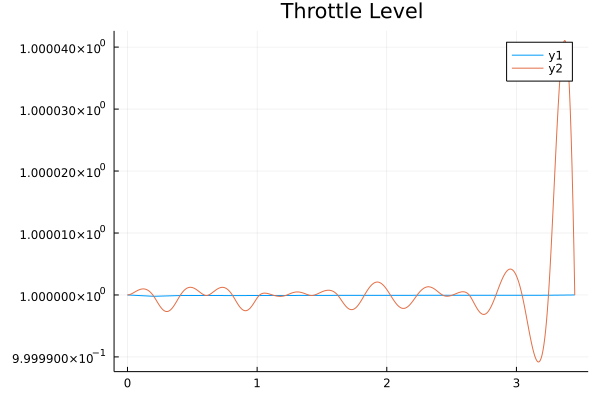

In [33]:
scp_new_problem.print(solution)
scp_new_problem.plot(solution)
# scp_new_problem.save(solution)

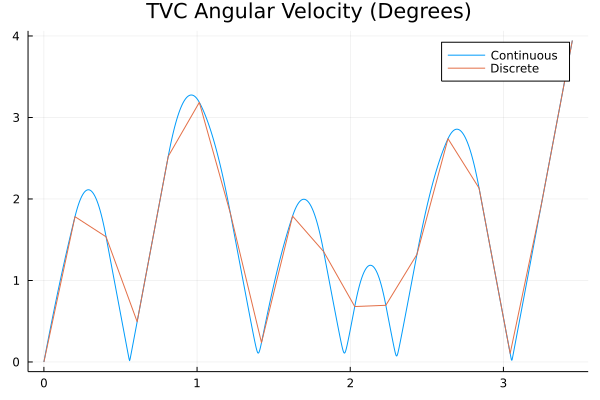

In [17]:
t_burn = 3.45

t_plot = LinRange(0, 1, 1000) * t_burn
Plots.plot(t_plot, [rad2deg(norm(sample(solution.xc, k)[17:19])) for k in t_plot / t_burn], title="TVC Angular Velocity (Degrees)", label = "Continuous")

t_plot = solution.td * t_burn
Plots.plot!(t_plot, [rad2deg(norm(sample(solution.xc, k)[17:19])) for k in t_plot / t_burn], label = "Discrete")

In [34]:
count(abs.(norm.(eachcol(solution.xd[7:10, :]))) .- 1 .> 1e-6) # check if quat norm is within 1e-6 of 1.

0